# Part 3.
    1). Image Segmentation of the brain via the Preprocessed OA-SISdataset  

In [25]:
# Upload necessary lobraries for the CNN.
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
#To see our directory
import os
import random
#Gabage collector for cleaning deleted data from memory
import gc

# Load DataSet from local directory and pick dataset as imageset.

In [26]:
train_dir = 'C:/Users/86171/input/train'
test_dir = 'C:/Users/86171/input/test'
#get tumor images
train_tumor = ['C:/Users/86171/input/train/{}'.format(i) for i in os.listdir(train_dir) if 'seg' in i]  
#get normal images
train_normal = ['C:/Users/86171/input/train/{}'.format(i) for i in os.listdir(train_dir) if 'case' in i] 
#get test images
test_imgs = ['C:/Users/86171/input/test/{}'.format(i) for i in os.listdir(test_dir)]
# slice the dataset and use 2000 in each class 
train_imgs = train_normal[:2000] + train_tumor[:2000]
# shuffle it randomly
random.shuffle(train_imgs)

#Clear list that are useless
del train_tumor
del train_normal
gc.collect()   #collect garbage to save memory


28

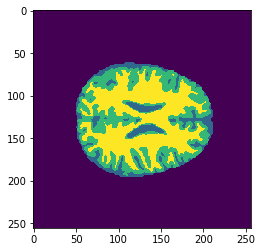

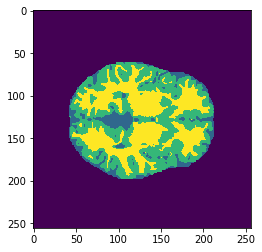

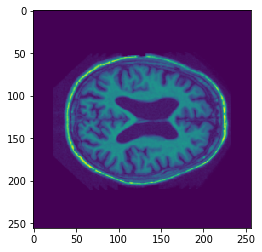

In [3]:
# Check the images of the uploaded dataset.
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [4]:
#Lets declare our image dimensions
#we are using coloured images. 
nrows = 150
ncolumns = 150
channels = 3  #change to 1 if you want to use grayscale image

#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        #Read the image
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  
        #get the labels
        if 'seg' in image:
            y.append(1)
        elif 'case' in image:
            y.append(0)
    
    return X, y

In [5]:
#get the train and label data
X, y = read_and_process_image(train_imgs)

In [27]:
# Data preprocessing

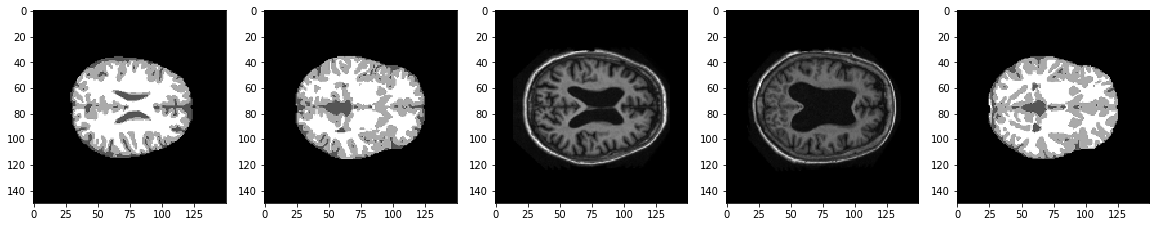

In [6]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

Text(0.5, 1.0, 'Labels for Normal and Tumor')

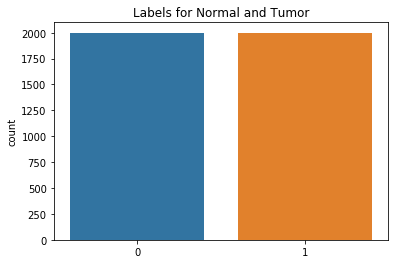

In [7]:
import seaborn as sns
del train_imgs
gc.collect()

#Convert list to numpy array
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Labels for Normal and Tumor')

In [8]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (4000, 150, 150, 3)
Shape of labels is: (4000,)


In [9]:
#Lets split the data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (3200, 150, 150, 3)
Shape of validation images is: (800, 150, 150, 3)
Shape of labels is: (3200,)
Shape of labels is: (800,)


In [10]:
#clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

# import the neccessary keras modules we are going to use

In [11]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  #Dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

Using TensorFlow backend.


We pass the rescale option to the ImageDataGenerator object. The rescale=1./255 option is a very IMPORTANT parameter. It normalizes the image pixel values to have zero mean and standard deviation of 1. It helps your model to generally learn and update its parameters efficiently.
The second set of options are Image augmentation options. They tell the ImageDataGenerator to randomly apply some transformation to the Image. This will help to augment our data-set and improve generalization.
Here we also create an ImageDataGenerator object for our validation set. Note: we don’t do data augmentation here. We only perform rescale.

In [12]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)
#We do not augment validation data. we only perform rescale#Lets see our model
val_datagen = ImageDataGenerator(rescale=1./255)  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [13]:
#We'll use the RMSprop optimizer with a learning rate of 0.0001
#We'll use binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [15]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [16]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [17]:
#The training part
#We train for 64 epochs with about 100 steps per epoch
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=64,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/64
100/100 [==============================] - 39s 388ms/step - loss: 0.2702 - acc: 0.8825 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 2/64
100/100 [==============================] - 37s 375ms/step - loss: 0.0589 - acc: 0.9794 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 3/64
100/100 [==============================] - 38s 376ms/step - loss: 0.0310 - acc: 0.9897 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4/64
100/100 [==============================] - 38s 385ms/step - loss: 0.0292 - acc: 0.9900 - val_loss: 1.0698e-04 - val_acc: 1.0000
Epoch 5/64
100/100 [==============================] - 39s 394ms/step - loss: 0.0127 - acc: 0.9947 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 6/64
100/100 [==============================] - 39s 391ms/step - loss: 0.0204 - acc: 0.9956 - val_loss: 0.0103 - val_acc: 0.9887
Epoch 7/64
100/100 [==============================] - 40s 399ms/step - loss: 0.0132 - acc: 0.9956 - val_loss: 1.6389e-04 - val_acc: 1.0000
Epoch 8/64
100/100 [===========================

100/100 [==============================] - 40s 395ms/step - loss: 1.0779e-05 - acc: 1.0000 - val_loss: 2.7956e-11 - val_acc: 1.0000
Epoch 60/64
100/100 [==============================] - 40s 396ms/step - loss: 6.2170e-06 - acc: 1.0000 - val_loss: 5.2473e-16 - val_acc: 1.0000
Epoch 61/64
100/100 [==============================] - 40s 397ms/step - loss: 1.9182e-06 - acc: 1.0000 - val_loss: 3.2348e-13 - val_acc: 1.0000
Epoch 62/64
100/100 [==============================] - 40s 404ms/step - loss: 0.0018 - acc: 0.9997 - val_loss: 7.2379e-17 - val_acc: 1.0000
Epoch 63/64
100/100 [==============================] - 40s 395ms/step - loss: 6.8890e-07 - acc: 1.0000 - val_loss: 1.4201e-10 - val_acc: 1.0000
Epoch 64/64
100/100 [==============================] - 39s 389ms/step - loss: 6.4934e-04 - acc: 0.9997 - val_loss: 9.3378e-15 - val_acc: 1.0000


Next, we save our model, with the simple Keras function shown below, this way we can re-use it anytime instead of training again when rerunning our notebook.

In [18]:
#Save the model
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

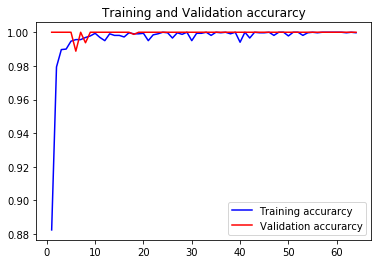

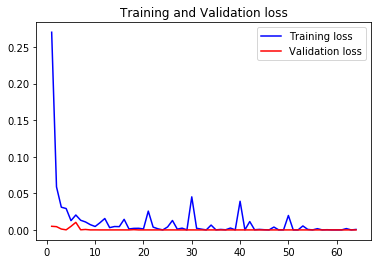

In [19]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

First thing to note is that we’re not overfitting as the train and validation accuracy are pretty close and following each other.
We can also notice that the accuracy keeps increasing as the epoch increases, giving us the intuition that increasing the epoch size will likely give us a higher accuracy.

In [20]:
#Now lets predict on the first 10 Images of the test set
X_test, y_test = read_and_process_image(test_imgs[0:10]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

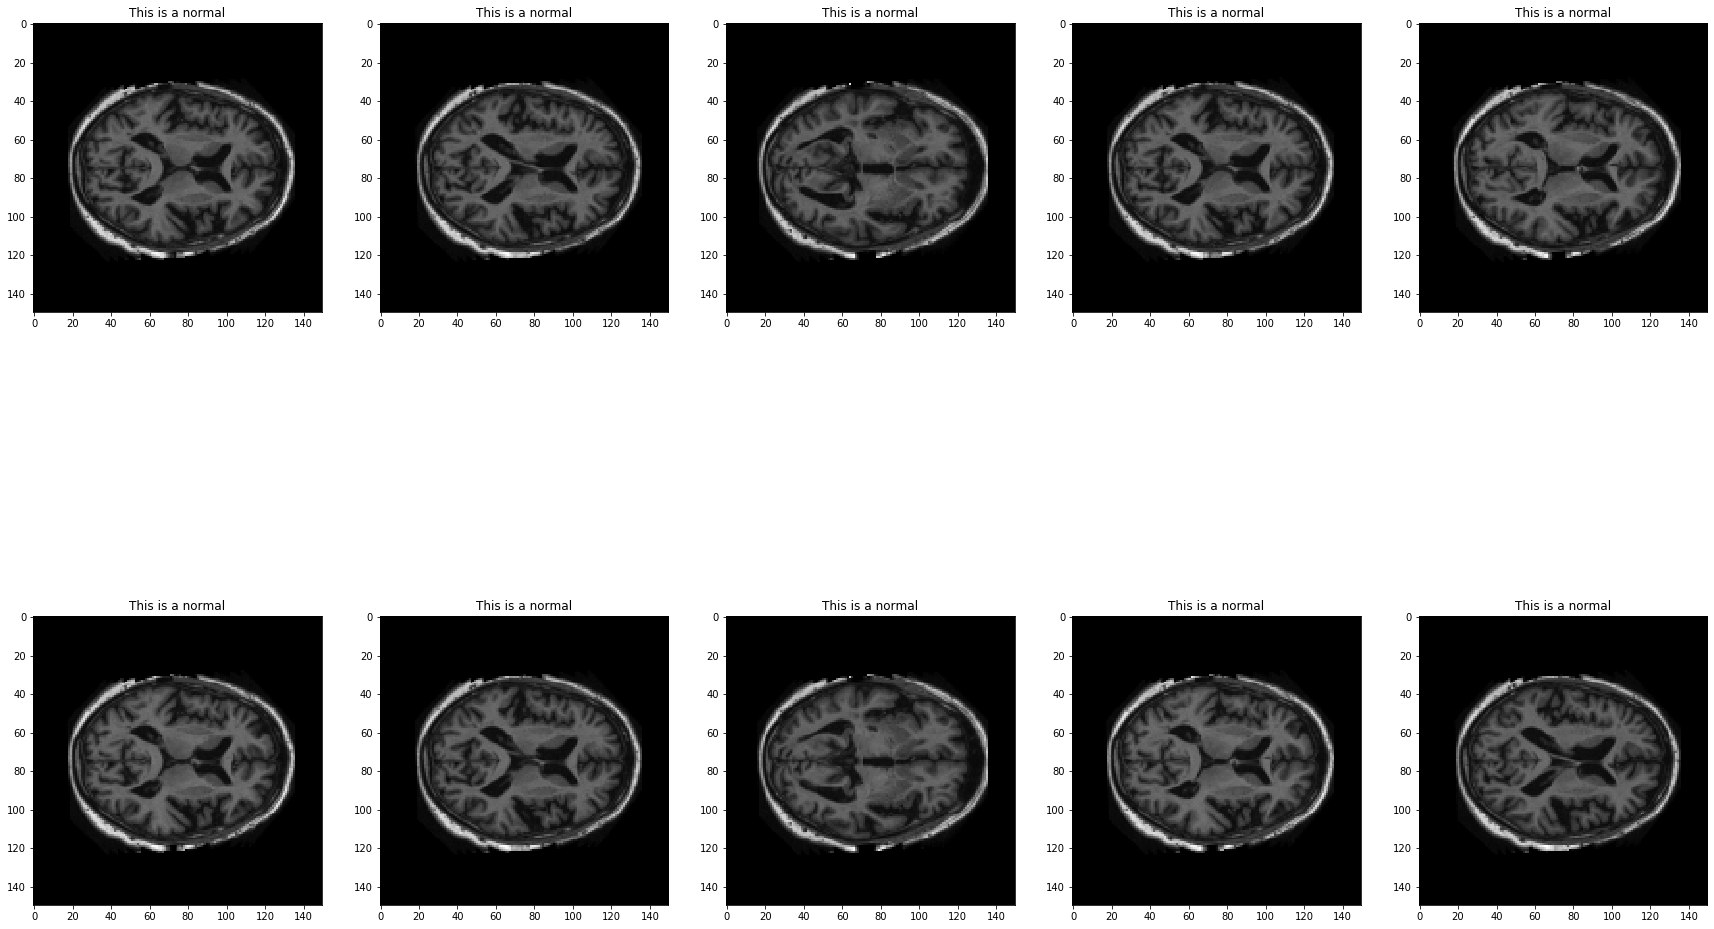

In [23]:
i = 0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('tumor')
    else:
        text_labels.append('normal')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()